# Business Understanding

Our stake holders are companies that flip houses in King County, Washington. We are using data gathered from houses sold in that area to predict whether our stake holders should invest in certain houses or not, as well as where would be the best place to locate their company.

# Data Understanding

We used data from houses that have sold in King County over the years to predict the housing prices of current homes. Using this, we can conclude whether a house is over-valued or under-valued. Based on this prediction, we can see whether it is worth it to flip a house. If a house is under-valued, then there is a good estimated profit to be made from flipping it.

# Data Preperation

### Import

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.impute import SimpleImputer
from utils import evaluate_model as em
from sklearn.feature_selection import RFE
from matplotlib.ticker import StrMethodFormatter

### Data Frame

In [2]:
df = pd.read_csv('data/kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


### Cleaning

In [3]:
df = df.loc[df['view'] == 'NONE']
df = df.drop(columns = ['yr_renovated', 'id', 'date', 'floors', 'view', 'lat', 'long', 'waterfront'])
df['grade_clean'] = df['grade'].str[:2].astype(int)
df = df.drop(columns = 'grade')
df['sqft_basement_clean'] = df['sqft_living'] - df['sqft_above']
df = df.drop(columns = 'sqft_basement')

map = { 
    'Poor'      :    1,  
    'Fair'      :    2,
    'Average'   :    3,
    'Good'      :    4,
    'Very Good' :    5
}
df['condition'] = df['condition'].map(map)

### Creating New Column

In [4]:
grade_group = []
for grade in df['grade_clean']:
    if grade >= 10:
        grade_group.append(2)
    elif grade <= 6:
        grade_group.append(0)
    else:
        grade_group.append(1)
        
df['grade_group'] = grade_group

### Exploratory Data Analysis

<AxesSubplot:>

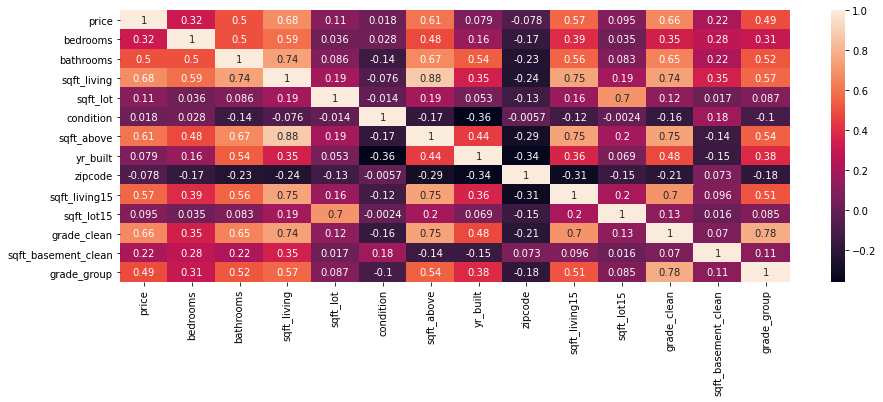

In [5]:
fig, ax = plt.subplots(figsize= (15, 5))
sns.heatmap(df.corr(), annot = True)

### Fixing Colinearity

In [6]:
df_no_co = df.copy()

In [7]:
df_no_co = df_no_co.drop(columns = ['bathrooms', 'sqft_above', 'sqft_living15', 'grade_clean'])

<AxesSubplot:>

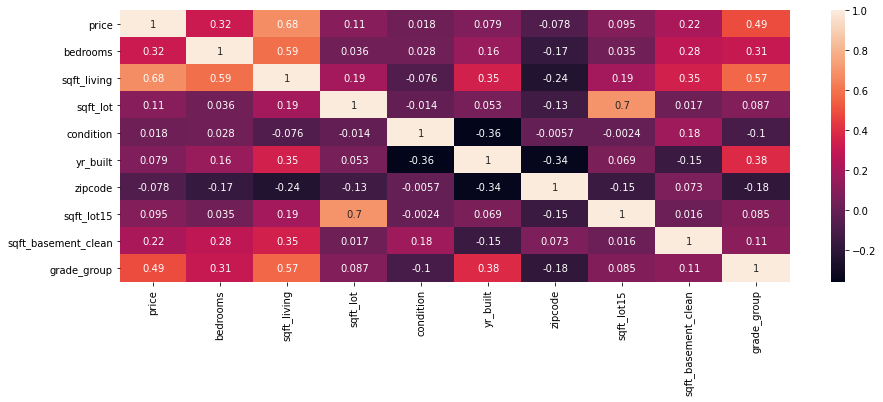

In [8]:
fig, ax = plt.subplots(figsize= (15, 5))
sns.heatmap(df_no_co.corr(), annot = True)

# Modeling

In [9]:
X = df_no_co.drop(columns='price')
y = df_no_co['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   test_size=0.25, 
                                                    random_state=42)

In [10]:
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

In [51]:
cat_cols = ['zipcode']

encoder = OneHotEncoder(drop=[98002])

ct = ColumnTransformer(transformers=[('ohe', encoder, cat_cols)],
                       remainder='passthrough', sparse_threshold=0)

ct.fit(X_train)

# X_train_enc = pd.DataFrame(ct.transform(X_train), columns=ct.get_feature_names())
X_train_enc =ct.transform(X_train)

X_test_enc = ct.transform(X_test)

## Baseline Model

In [53]:
X_train_2 = X_train[['sqft_living']]
X_test_2 = X_test[['sqft_living']]

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.457
Model:                            OLS   Adj. R-squared:                  0.457
Method:                 Least Squares   F-statistic:                 1.228e+04
Date:                Fri, 01 Jul 2022   Prob (F-statistic):               0.00
Time:                        10:11:54   Log-Likelihood:            -1.9900e+05
No. Observations:               14566   AIC:                         3.980e+05
Df Residuals:                   14564   BIC:                         3.980e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        3.842e+04   4463.849      8.608      

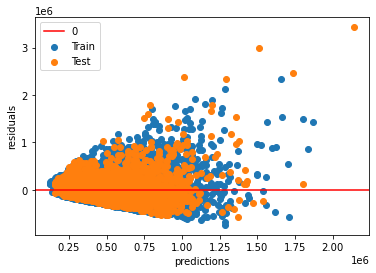

const          38423.300121
sqft_living      228.650934
dtype: float64

In [54]:
em(X_train_2, X_test_2, y_train, y_test)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.438
Model:                            OLS   Adj. R-squared:                  0.438
Method:                 Least Squares   F-statistic:                 1.135e+04
Date:                Fri, 01 Jul 2022   Prob (F-statistic):               0.00
Time:                        10:11:55   Log-Likelihood:                -6051.8
No. Observations:               14566   AIC:                         1.211e+04
Df Residuals:                   14564   BIC:                         1.212e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          12.2120      0.008   1549.054      

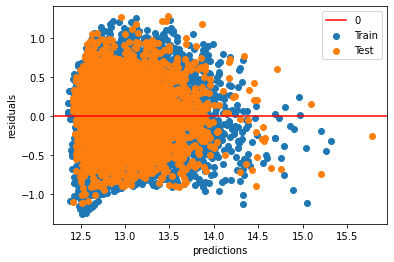

const          12.211986
sqft_living     0.000388
dtype: float64

In [55]:
em(X_train_2, X_test_2, y_train_log, y_test_log)

## Kitchen Sink Model

In [56]:
X_train_3 = X_train_enc
X_test_3 = X_test_enc

In [57]:
scaler = StandardScaler()
scaler.fit(X_train_3)

X_train_3_sc = scaler.transform(X_train_3)
X_test_3_sc = scaler.transform(X_test_3)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     823.7
Date:                Fri, 01 Jul 2022   Prob (F-statistic):               0.00
Time:                        10:11:56   Log-Likelihood:            -1.9120e+05
No. Observations:               14566   AIC:                         3.826e+05
Df Residuals:                   14488   BIC:                         3.832e+05
Df Model:                          77                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.948e+05   1009.605    490.123      0.0

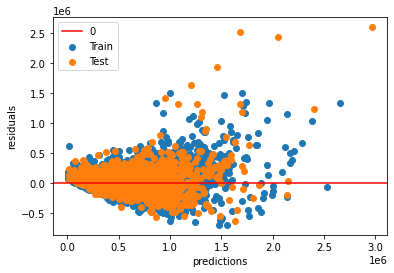

In [58]:
params = em(X_train_3_sc, X_test_3_sc, y_train, y_test)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     1065.
Date:                Fri, 01 Jul 2022   Prob (F-statistic):               0.00
Time:                        10:11:58   Log-Likelihood:                 3559.1
No. Observations:               14566   AIC:                            -6962.
Df Residuals:                   14488   BIC:                            -6370.
Df Model:                          77                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.9870      0.002   8248.322      0.0

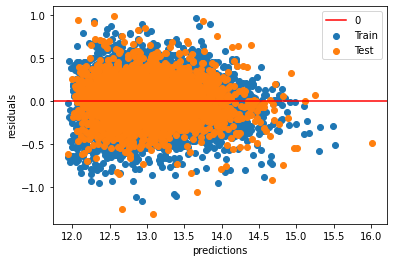

In [59]:
params = em(X_train_3_sc, X_test_3_sc, y_train_log, y_test_log, log = True)

In [60]:
p = pd.DataFrame(params)

In [61]:
p['names'] = ['const', *ct.get_feature_names()]

In [62]:
p.sort_values(by = 0, ascending = False).head(10)

,0,names
const,12.986957,const
x71,0.271140,sqft_living
x42,0.147612,ohe__x0_98103
x49,0.145059,ohe__x0_98115
x3,0.143554,ohe__x0_98004
x51,0.136683,ohe__x0_98117
x48,0.130994,ohe__x0_98112
x28,0.123952,ohe__x0_98052
x21,0.116250,ohe__x0_98033
x43,0.105151,ohe__x0_98105


In [38]:
X_train_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14566 entries, 0 to 14565
Data columns (total 78 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ohe__x0_98002        14566 non-null  object
 1   ohe__x0_98003        14566 non-null  object
 2   ohe__x0_98004        14566 non-null  object
 3   ohe__x0_98005        14566 non-null  object
 4   ohe__x0_98006        14566 non-null  object
 5   ohe__x0_98007        14566 non-null  object
 6   ohe__x0_98008        14566 non-null  object
 7   ohe__x0_98010        14566 non-null  object
 8   ohe__x0_98011        14566 non-null  object
 9   ohe__x0_98014        14566 non-null  object
 10  ohe__x0_98019        14566 non-null  object
 11  ohe__x0_98022        14566 non-null  object
 12  ohe__x0_98023        14566 non-null  object
 13  ohe__x0_98024        14566 non-null  object
 14  ohe__x0_98027        14566 non-null  object
 15  ohe__x0_98028        14566 non-null  object
 16  ohe_

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     1065.
Date:                Fri, 01 Jul 2022   Prob (F-statistic):               0.00
Time:                        10:12:04   Log-Likelihood:                 3559.1
No. Observations:               14566   AIC:                            -6962.
Df Residuals:                   14488   BIC:                            -6370.
Df Model:                          77                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.2293      0.149     75.478      0.0

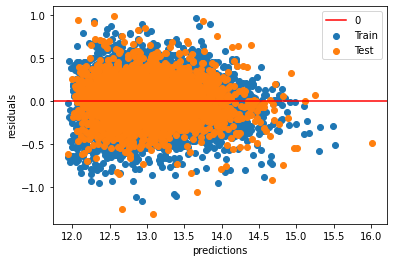

In [63]:
params_unsc = em(X_train_3, X_test_3, y_train_log, y_test_log, log = True)

In [64]:
p_unsc = pd.DataFrame(params_unsc)

In [65]:
p_unsc['names'] = ['const', *ct.get_feature_names()]

In [66]:
p_unsc.sort_values(by = 0, ascending = False).head(20)

,0,names
const,11.229300,const
x24,1.378749,ohe__x0_98039
x3,1.207121,ohe__x0_98004
x48,1.172937,ohe__x0_98112
x53,1.082349,ohe__x0_98119
x47,1.081622,ohe__x0_98109
x41,1.040445,ohe__x0_98102
x25,1.024601,ohe__x0_98040
x43,1.021550,ohe__x0_98105
x69,0.947785,ohe__x0_98199


In [68]:
(np.expm1(3.252895e-04) * 100) * 500000

16267.120618326435

### Square Feet Against Price

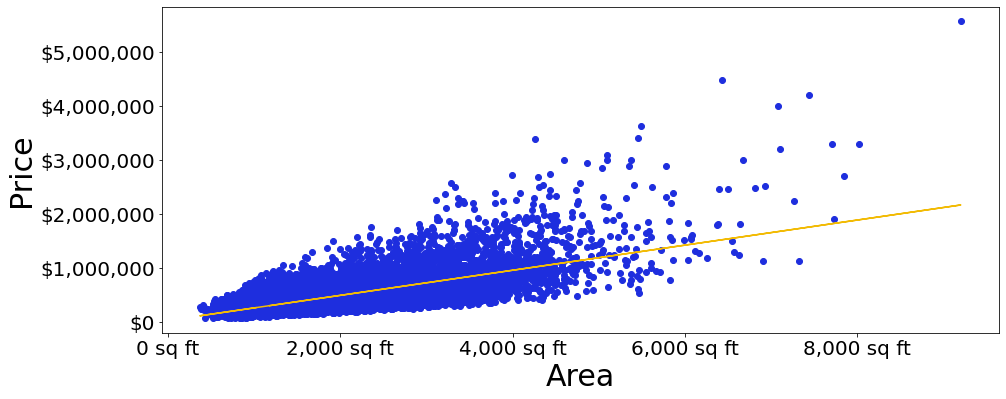

In [105]:
x = df['sqft_living']
y = df['price']
plt.figure(figsize=(15, 6))
plt.scatter(x, y, color = '#1E2EDE')

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x), color="#F2BB05")

ax = plt.gca()
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f} sq ft'))
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))

plt.rc('axes', labelsize=30)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20) 

plt.ylabel('Price')
plt.xlabel('Area')
plt.show()

### Top 5 Cheapest Zipcodes

In [79]:
df_zip_price = df.copy()
df_zip_pricet = df.copy()

In [80]:
df_zip_price['zipcode'] = df_zip_price['zipcode'].astype(str)

In [81]:
df_zip_price = dict(df_zip_price.groupby('zipcode')["price"].mean().sort_values(ascending = True)[:5])

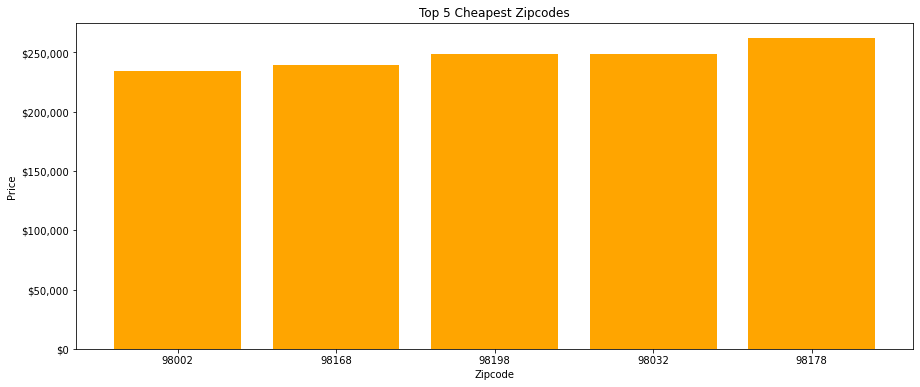

In [84]:
x = df_zip_price.keys()
y = df_zip_price.values()
plt.figure(figsize=(15, 6))
plt.bar(x, y, color = 'orange')

ax = plt.gca()
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))

plt.ylabel('Price')
plt.xlabel('Zipcode')
plt.title('Top 5 Cheapest Zipcodes')
plt.show()

# Evalutation

# Limitations

# Conclusions

# Next Steps

- Isolate homes below average compared to neighbors
- Identify the effects on other features due to change in condition
- Pull data on trending areas around Seattle 
- Further data cleanse 